In [1]:
#Import some modules
import numpy as np
import pandas as pd
from scipy import interp
%matplotlib inline
import matplotlib.pyplot as plt
import model_fitting as mfit
import loan_roi as lr

from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Read in the training, test, and validation data sets
X_train = pd.read_pickle('X_train')
y_train = pd.read_pickle('y_train')
X_test = pd.read_pickle('X_test')
y_test = pd.read_pickle('y_test')
X_val = pd.read_pickle('X_val')
y_val = pd.read_pickle('y_val')
ROI = pd.read_pickle('ROI')

In [17]:
#Get the list of reliable features
reliable_feat = mfit.get_reliable_features(X_train, y_train)

In [26]:
#Get reliable features without loan amount and interest rate
reliable_feat_no_amnt_intr = mfit.get_reliable_features(X_train.drop(['int_rate', 'loan_amnt'], axis = 1), 
                                                        y_train)

In [13]:
#Train Naive Bayes classifier, one feature at at time, in order of importance, significant features only
#Performance deteriorates after about twenty features, only train on those twenty
NB_clf = GaussianNB()
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=42)

NB_feat_df = mfit.add_feature_auc(X_train, y_train, X_val, y_val, NB_clf, cv, 44)
NB_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.675513,0.003280,0.675547,0.671889
2,0.681346,0.002145,0.681421,0.678705
3,0.675575,0.002265,0.675647,0.672104
4,0.675659,0.002861,0.675767,0.673606
5,0.673597,0.003007,0.673673,0.672332
6,0.674850,0.003426,0.676686,0.674615
7,0.677187,0.003328,0.679105,0.677364
8,0.677209,0.003299,0.679125,0.677499
9,0.676410,0.003051,0.678467,0.677938
10,0.676087,0.002835,0.677905,0.680038


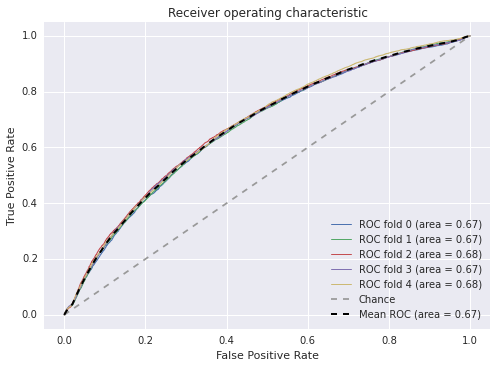

In [20]:
#Train Naive Bayes on 20 most reliable features and plot ROC
#Training AUC is 0.67
_, NB_clf = mfit.fit_plot_ROC(X_train[reliable_feat.index[0:19]], y_train, NB_clf, cv)

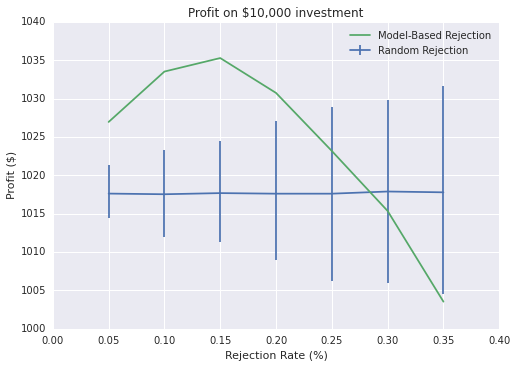

In [22]:
#Look at performance in monetary terms for validation set
probas_ = NB_clf.predict_proba(X_val[reliable_feat.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat.index[0:19]].index)
pred_ROI = ROI.loc[X_val[reliable_feat.index[0:19]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [23]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1026.957432,1017.623532,1021.346667,1014.446094,1245.888302
0.10,1033.527778,1017.537733,1023.280448,1012.017968,1245.888302
0.15,1035.289048,1017.686160,1024.475781,1011.300325,1245.888302
0.20,1030.742857,1017.611091,1027.051163,1008.923835,1245.888302
0.25,1023.178863,1017.611563,1028.959776,1006.244986,1245.888302
0.30,1015.357756,1017.893935,1029.864644,1006.010551,1245.888302
0.35,1003.540000,1017.787825,1031.616667,1004.587802,1245.888302


In [28]:
#Test adding features one at a time for Naive Bayes without including the interest rate or loan amount
#Performance peaks at around 20 features
NB_feat_df = mfit.add_feature_auc(X_train.drop(['int_rate', 'loan_amnt'], axis = 1),
                                  y_train, X_val.drop(['int_rate', 'loan_amnt'], axis = 1), y_val, NB_clf, cv, 44)
NB_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.581662,0.003670,0.581645,0.580203
2,0.600759,0.003552,0.600827,0.598338
3,0.609814,0.002467,0.609913,0.610047
4,0.612405,0.002302,0.615079,0.614422
5,0.616374,0.002435,0.618963,0.618710
6,0.614606,0.002009,0.616944,0.616313
7,0.614414,0.002738,0.616656,0.616955
8,0.618085,0.002807,0.620035,0.623412
9,0.619788,0.002678,0.621728,0.624181
10,0.619862,0.002599,0.621826,0.623101


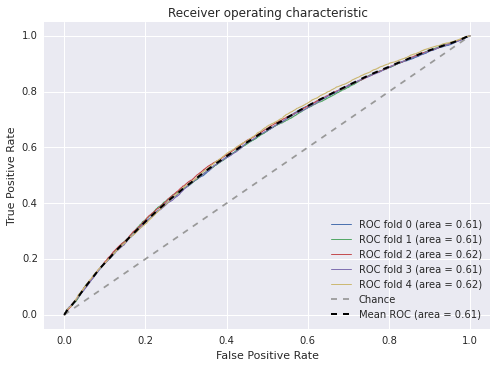

In [29]:
#Train Naive Bayes on 20 most reliable features (exclude interest and loan amount) and plot ROC
#Training AUC is 0.61
_, NB_clf = mfit.fit_plot_ROC(X_train[reliable_feat_no_amnt_intr.index[0:19]], y_train, NB_clf, cv)

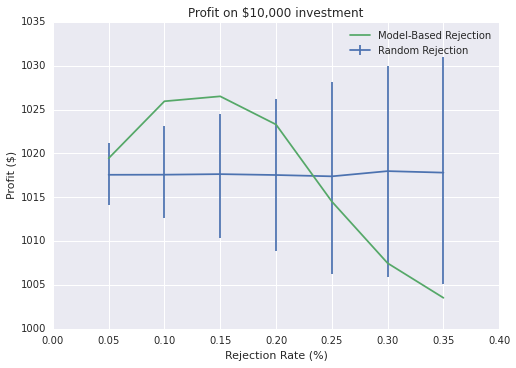

In [30]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = NB_clf.predict_proba(X_val[reliable_feat_no_amnt_intr.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr.index[0:19]].index)
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:19]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [31]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1019.445417,1017.564015,1021.237127,1014.123385,1245.888302
0.10,1025.950000,1017.575805,1023.166972,1012.620690,1245.888302
0.15,1026.511861,1017.639678,1024.476531,1010.393923,1245.888302
0.20,1023.297937,1017.538725,1026.252925,1008.924446,1245.888302
0.25,1014.517857,1017.387673,1028.192620,1006.245000,1245.888302
0.30,1007.483333,1017.982954,1029.990321,1005.914211,1245.888302
0.35,1003.533333,1017.810222,1031.020966,1005.132539,1245.888302


For the Naive Bayes classifier, I tested performance out to 44 features in order of reliability. Including the first 20 features alone led to peak performance. For this classifier, the area under the ROC curve is 0.67. If this classifier is used to reject the top 15% of loans with respect to riskiness, the return on a $10,000 investment would be $1035.29. This return reliable is above the chance return, calculated by randomly dropping 15 percent of the loans (bootstrapping analysis). It is important to note that perfect rejection (i.e., only loans that default) would yield a return of $1245.88. This value represents the best possible performance. 

One caveat is that I have included interest rate and loan amount. The interest rate is directly assigned by the Lending Club using their in-house risk metrics and the loan amount may be as well. When these values are excluded, the area under the ROC curve drops to 0.61. In monetary terms, the return on a $10,000 investment would be $1026.51 if the top 15 percent of risky loans are rejected. This is still better performance than chance

In [32]:
#Train Logistic Regression classifier, one feature at at time, in order of importance, significant features only
#Performance increases as the number of features increases, use all 44
LR_clf = LogisticRegression(penalty='l2', C=1, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
LR_feat_df = mfit.add_feature_auc(X_train, y_train, X_val, y_val, LR_clf, cv, 44)
LR_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.675513,0.003280,0.675547,0.671889
2,0.682182,0.002367,0.682294,0.678927
3,0.682157,0.002368,0.682224,0.678648
4,0.682911,0.002512,0.683002,0.679916
5,0.682921,0.002515,0.683010,0.679934
6,0.692820,0.002803,0.692901,0.691771
7,0.693241,0.002978,0.693362,0.692659
8,0.693344,0.003033,0.693435,0.692797
9,0.693304,0.002948,0.693433,0.692688
10,0.695123,0.002774,0.695200,0.695473


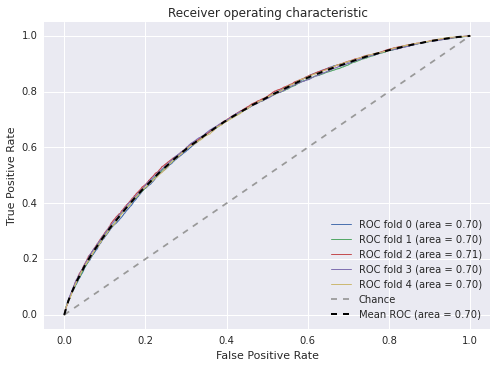

In [33]:
#Train Logistic Regression on 44 most reliable features and plot ROC
#Training AUC is 0.70
_, LR_clf = mfit.fit_plot_ROC(X_train[reliable_feat.index[0:43]], y_train, LR_clf, cv)


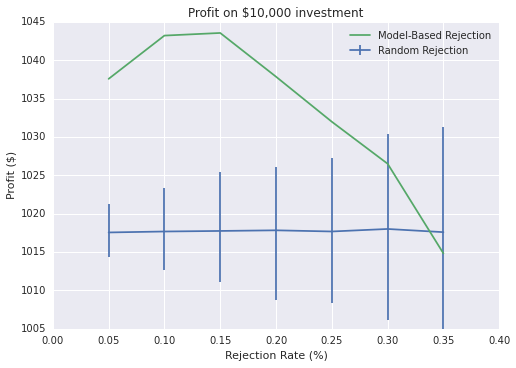

In [34]:
#Look at performance in monetary terms for validation set
probas_ = LR_clf.predict_proba(X_val[reliable_feat.index[0:43]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat.index[0:43]].index)
pred_ROI = ROI.loc[X_val[reliable_feat.index[0:43]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [35]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1037.574521,1017.557265,1021.308627,1014.326406,1245.888302
0.10,1043.216667,1017.682241,1023.297937,1012.620172,1245.888302
0.15,1043.557408,1017.753758,1025.425292,1011.057234,1245.888302
0.20,1037.857143,1017.836473,1026.103571,1008.720804,1245.888302
0.25,1031.986441,1017.683580,1027.300000,1008.343169,1245.888302
0.30,1026.511861,1018.011131,1030.431010,1006.096312,1245.888302
0.35,1014.826087,1017.595803,1031.296970,1005.021945,1245.888302


In [36]:
#Test adding features one at a time for Logistic Regression without including the interest rate or loan amount
#Performance continues increasing as features are added
LR_feat_df = mfit.add_feature_auc(X_train.drop(['int_rate', 'loan_amnt'], axis = 1),
                                  y_train, X_val.drop(['int_rate', 'loan_amnt'], axis = 1), y_val, LR_clf, cv, 44)
LR_feat_df

,cv_auc,cv_std,train_auc,val_auc
1,0.581662,0.003670,0.581645,0.580203
2,0.600679,0.003975,0.600725,0.597512
3,0.612185,0.002446,0.612277,0.612407
4,0.625552,0.002181,0.625647,0.627787
5,0.627120,0.002305,0.627196,0.629034
6,0.627246,0.002241,0.627339,0.628929
7,0.627545,0.002511,0.627605,0.628697
8,0.632413,0.002507,0.632526,0.636154
9,0.636515,0.002276,0.636633,0.639030
10,0.637575,0.001709,0.637788,0.639382


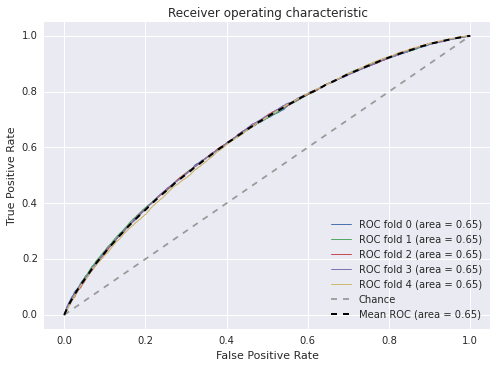

In [37]:
#Train Logistic Regression on 44 most reliable features (exclude interest and loan amount) and plot ROC
#Training AUC is 0.65
_, LR_clf = mfit.fit_plot_ROC(X_train[reliable_feat_no_amnt_intr.index[0:43]], y_train, LR_clf, cv)

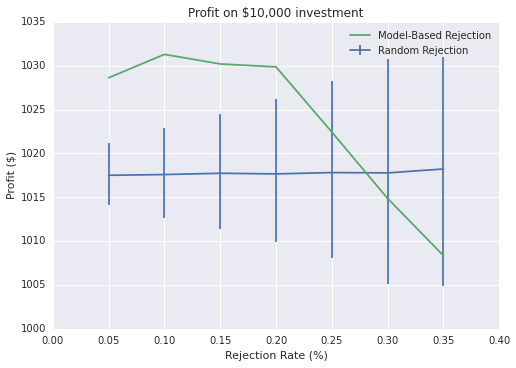

In [38]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = LR_clf.predict_proba(X_val[reliable_feat_no_amnt_intr.index[0:43]])
prob_default = pd.Series(data = probas_[:,1], index=X_val[reliable_feat_no_amnt_intr.index[0:43]].index)
pred_ROI = ROI.loc[X_val[reliable_feat_no_amnt_intr.index[0:43]].index]
pred_ROI['default'] = y_val
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [39]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1028.628689,1017.509585,1021.237127,1014.123385,1245.888302
0.10,1031.296970,1017.591380,1022.882502,1012.600000,1245.888302
0.15,1030.204966,1017.738223,1024.476531,1011.354167,1245.888302
0.20,1029.866669,1017.665061,1026.257885,1009.899924,1245.888302
0.25,1022.437143,1017.815073,1028.316434,1008.102632,1245.888302
0.30,1014.865424,1017.779350,1030.741109,1005.160772,1245.888302
0.35,1008.348214,1018.226637,1030.991429,1004.906884,1245.888302


For the Logistic Regression classifier, I tested performance out to 44 features in order of reliability. Including the all features led to peak performance. For this classifier, the area under the ROC curve is 0.70. If this classifier is used to reject the top 15% of loans with respect to riskiness, the return on a $10,000 investment would be $1043.55. This return reliable is above the chance return. Perfect rejection (i.e., only loans that default) would yield a return of $1245.88. 

Excluding the interest rate and loan amount, the area under the ROC curve drops to 0.649. In monetary terms, the return on a $10,000 investment would be $1030.20 if the top 15 percent of risky loans are rejected. This is still better performance than chance